# Transfer Learning with TensorFlow Part 2: Fine Tuning

In the previous part the part 1 we have learned about the feature extraction part of transfer learning now it's time to learn about new kind of transfer learning :*fine tuning*

>**How to use tensorboard locally**\
>*tensorboard --logdir=tensorflow_hub/(this is the directory name)*

## Creating helper functions

In previous notebooks ,we have created a bunch of helper functions,now we could rewrite them all,however this is tedious.

so,its a good idea to put functins you'll want to use use again ina script you can download and import into your notebooks(or elsewhere).

We've done this for some of the functions we've previously used here: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py

In [4]:
# Import the helper functions we are going to use in this notebook
from helper_functions import create_tensorboard_callback,unzip_data,plot_loss_curves,unzip_data,walk_through_dir

## Let's get some data

This time we're going to see how we can use the pretrained models within `tf.keras.appliactions` and apply them to our own problem(recogizing images of food).

link:https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [2]:
# Get 10% of training data of 10 classes
unzip_data("10_food_classes_10_percent.zip")

In [3]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [2]:
# Create training and test directory patsh
train_dir="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [3]:
import tensorflow as tf

In [4]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                          image_size=IMG_SIZE,
                                                                          label_mode="categorical",
                                                                          batch_size=BATCH_SIZE)

test_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                         batch_size=BATCH_SIZE,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode="categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [8]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [9]:
# See an example of a batch of data
for images,labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[155.85715    95.85715    43.85714  ]
   [164.59694   104.71429    57.16837  ]
   [174.91837   116.34694    72.28571  ]
   ...
   [182.1428     78.50002    62.142815 ]
   [174.40303    82.73982    59.642868 ]
   [168.40303    90.41842    62.7041   ]]

  [[145.33163    82.47449    28.47449  ]
   [147.4847     84.55612    30.770405 ]
   [153.64285    92.158165   41.22959  ]
   ...
   [173.1836     76.28049    57.59679  ]
   [158.0663     66.352066   43.280624 ]
   [159.92874    79.28592    52.285923 ]]

  [[147.07654    80.64796    20.433674 ]
   [142.39795    76.39796    16.183672 ]
   [138.97958    74.36225    15.887756 ]
   ...
   [174.81618    96.79066    71.576324 ]
   [169.35202    94.224495   65.51019  ]
   [160.061      88.984566   58.98453  ]]

  ...

  [[174.35207    98.35207    46.35207  ]
   [170.21428    94.21429    42.214287 ]
   [173.38268    97.168396   44.739822 ]
   ...
   [160.         93.785736   36.428528 ]
   [159.78574    93.785736   35.785736 ]
   [1

## Model 0 (Baseline Model): Building a transfer learning feature extraction model using teh Keras Functional API

The sequential API is straight forward , it runs our layers in a sequentials order.
But the functional API gives us more flexibility with our models

In [14]:
# Importing and Initializing the weights and biases callback
import wandb
wandb.login()
from wandb.integration.keras import WandbCallback

wandb: Currently logged in as: vuduthasaipraneetham (praneetham) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [30]:
model_0_config={
    "architecture":"EfficientNet_B0",
    "num_classes": len(train_data_10_percent.class_names),
    "loss":"categorical_crossentropy",
    "learning_rate":0.001,
    "optimizer":"Adam",
    "batch_size":BATCH_SIZE,
    "epochs":10,
    "dataset":"ImageNet",
    "dataset_fraction":"10%"
}

In [12]:
wandb.init(project="Transfer Learning Feature Extraction",
           name="Base Model(EfficientNetB0)",
           config=model_0_config)

In [13]:
# 1. Create a Baseline model with tf.keras.applications
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns arre'nt updated during training)
base_model.trainable=False

# 3. Create inputs into our model
inputs=tf.keras.layers.Input(shape=(224,224,3),name="input_layer")

# 4. If you are using ResNet50v2 you will need to normalize  the inputs(you don't have to do this for EffiecientNet)
# x=tf.keras.layers.experimental.preprocessing.Rescaling(1./225)(inputs)

# 5. Pass the inputs ot the base_model
x=base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most imoprtant information,reduce the number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_avg_pooling_layer")(x)
print(f"Shape after the GlobalAveragePooling2D: {x.shape}")

# 7.Create theouput activation layer
outputs=tf.keras.layers.Dense(10,activation="softmax",name="output_layer")(x)

# 8 . Combine the inputs with the outputs into a model
model_0=tf.keras.Model(inputs,outputs)

# 9. Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

# 10. Fit the model and saving it's history
history=model_0.fit(train_data_10_percent,
                    epochs=10,
                    steps_per_epoch=len(train_data_10_percent),
                    validation_data=test_data_10_percent,
                    validation_steps=len(test_data_10_percent),
                    callbacks=[WandbCallback()]
                    )

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.
wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after the GlobalAveragePooling2D: (None, 1280)
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 1.8835 - accuracy: 0.4347

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 55s 2s/step - loss: 1.8835 - accuracy: 0.4347 - val_loss: 1.3235 - val_accuracy: 0.7432
Epoch 2/10
23/24 [===========================>..] - ETA: 0s - loss: 1.1462 - accuracy: 0.7473

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 54s 2s/step - loss: 1.1437 - accuracy: 0.7440 - val_loss: 0.8971 - val_accuracy: 0.8268
Epoch 3/10
23/24 [===========================>..] - ETA: 0s - loss: 0.8445 - accuracy: 0.8016

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 67s 3s/step - loss: 0.8394 - accuracy: 0.8053 - val_loss: 0.7233 - val_accuracy: 0.8364
Epoch 4/10
23/24 [===========================>..] - ETA: 0s - loss: 0.7046 - accuracy: 0.8410

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 67s 3s/step - loss: 0.6998 - accuracy: 0.8427 - val_loss: 0.6229 - val_accuracy: 0.8560
Epoch 5/10
23/24 [===========================>..] - ETA: 0s - loss: 0.5927 - accuracy: 0.8641

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 83s 4s/step - loss: 0.5915 - accuracy: 0.8640 - val_loss: 0.5651 - val_accuracy: 0.8652
Epoch 6/10
23/24 [===========================>..] - ETA: 0s - loss: 0.5220 - accuracy: 0.8791

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 61s 3s/step - loss: 0.5227 - accuracy: 0.8773 - val_loss: 0.5264 - val_accuracy: 0.8672
Epoch 7/10
23/24 [===========================>..] - ETA: 0s - loss: 0.4779 - accuracy: 0.8940

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 76s 3s/step - loss: 0.4772 - accuracy: 0.8933 - val_loss: 0.5005 - val_accuracy: 0.8692
Epoch 8/10
23/24 [===========================>..] - ETA: 0s - loss: 0.4342 - accuracy: 0.9062

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 79s 3s/step - loss: 0.4314 - accuracy: 0.9080 - val_loss: 0.4762 - val_accuracy: 0.8724
Epoch 9/10
23/24 [===========================>..] - ETA: 0s - loss: 0.3940 - accuracy: 0.9253

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 61s 3s/step - loss: 0.3966 - accuracy: 0.9253 - val_loss: 0.4580 - val_accuracy: 0.8736
Epoch 10/10
23/24 [===========================>..] - ETA: 0s - loss: 0.3609 - accuracy: 0.9185

INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250627_001246-pbt87cjf\files\model-best)... Done. 0.1s


24/24 [==============================] - 56s 2s/step - loss: 0.3586 - accuracy: 0.9200 - val_loss: 0.4438 - val_accuracy: 0.8752


In [14]:
# Evaluate on the full test dataset
model_0.evaluate(test_data_10_percent)

79/79 [==============================] - 5s 57ms/step - loss: 0.4438 - accuracy: 0.8752


[0.4438326060771942, 0.8751999735832214]

In [15]:
# Check the layers in our base model
for layer_number,layer in enumerate(base_model.layers):
    print(layer_number,layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [16]:
# How about we get the summary of our base model
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 normalization (Normalization)  (None, None, None,   0           ['rescaling[0][0]']              
                                3)                                                

In [17]:
# How about a summary of our whole model??
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_avg_pooling_layer (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5,932,122
Trainable params: 12,810
Non-trainable params: 5,919,312
_________________________________________________________________


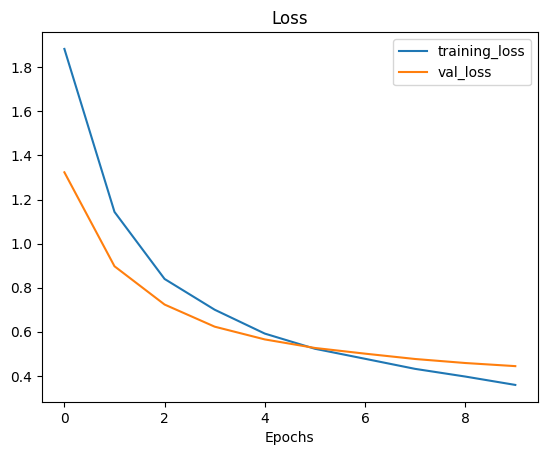

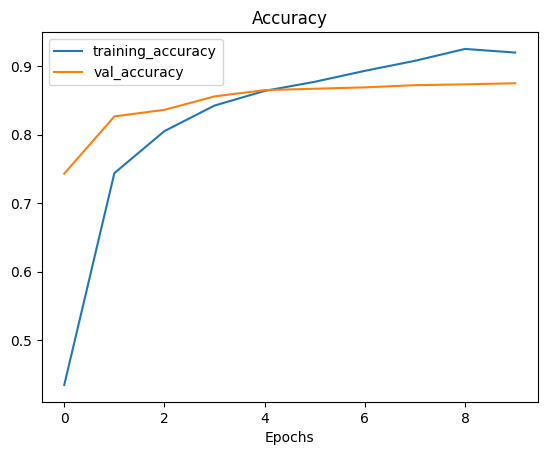

In [18]:
# Check out our model's training curves
plot_loss_curves(history)

## Getting the Feature vector from the Trained Model

Let's demonstrate the Global Avereage Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape(None,7,7,1280).

But then when it passes through GlobalAveragePooling@D,it turns into (None,1280).

Let's use a similar shaped tensor of (1,4,4,3) and then pass it to GlobalAveragePooling2D.

In [19]:
# Define the input shape
input_shape=(1,4,4,3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor=tf.random.normal(input_shape)
print(f"Random input tensor{input_tensor}")
print(f"Shape of the random tensor {input_tensor.shape}")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor=tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"\n2D Global average poooled random tensor:\n{global_average_pooled_tensor}")
print(f"Shape of Global Average Pooled 2D tensor{global_average_pooled_tensor.shape}")

Random input tensor[[[[ 0.3274686  -0.84262574  0.31943363]
   [-1.4075519  -2.3880599  -1.0392478 ]
   [-0.55732334  0.5397068   1.6994323 ]
   [ 0.28893673 -1.5066115  -0.26454768]]

  [[-0.5972241  -1.9171131  -0.6204413 ]
   [ 0.8504024  -0.40604776 -3.0258412 ]
   [ 0.9058464   0.2985598  -0.22561562]
   [-0.7616443  -1.891714   -0.9384712 ]]

  [[ 0.77852213 -0.4733889   0.9777269 ]
   [ 0.24694401  0.20573741 -0.52562326]
   [ 0.32410017  0.02545411 -0.1063849 ]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.40125775 -1.4145441 ]
   [-0.5931857  -1.6617213   0.33567154]
   [ 0.10815627  0.23479678 -0.5666875 ]
   [-0.35819858  0.8869861   0.52744764]]]]
Shape of the random tensor (1, 4, 4, 3)

2D Global average poooled random tensor:
[[0.9058464 1.1603122 1.6994323]]
Shape of Global Average Pooled 2D tensor(1, 3)


In [20]:
# Let's replicate the Global Average Pool 2D layer
tf.reduce_mean(input_tensor,axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368648, -0.45840448, -0.28855982]], dtype=float32)>

## Running a series of transfer learning experiments

We've seen teh incredible results transfer learning can get with only 10% of the training data,but how does it go with 1% of the training data,but how does it go with 1% of the training data ... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data augementation
3. `model_3` - use fine -tuning transfer learning on 10% of the training data with data augmentatin
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note** : Throughout all the experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics.


In [8]:
# Download and unzip data -preprocessed from Food 101
unzip_data("10_food_classes_1_percent.zip")

In [23]:
# Create training and test dirs
train_dir_1_percent="10_food_classes_1_percent/train"
test_dir="10_food_classes_1_percent/test"

In [24]:
# How many images we are working with??
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent\test'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent\test\sushi'

In [25]:
# Setup data loaders
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode="categorical",
                                                                         batch_size=BATCH_SIZE) #by default it is 32
test_data_1_percent=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                        image_size=IMG_SIZE,
                                                                        batch_size=BATCH_SIZE,
                                                                        label_mode="categorical")


Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data Augmentation right into the model

To add data augmentation right into our models,we can use the layers inside:

* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TEnsorflow Data Augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers

Off the top of heads, after reading the docs,the benfits of using data augmentation inside the model are:
* Preprocessing of images(augemtatng them) happens on the GPU (much faster) rather than the CPU.
* Image Data augemntation only happens during training, so we can still export our whole model and use it elsewhere.

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create data augmenation stage with horizontal flipping,roattions,zooms,etc
data_augmentation= keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    #preprocessing.Rescale(1./255) # Keep for models like ResNet50v2 but EfficientNet's having rescaaling built-in
],name="data_augmentation")


(-0.5, 383.5, 511.5, -0.5)

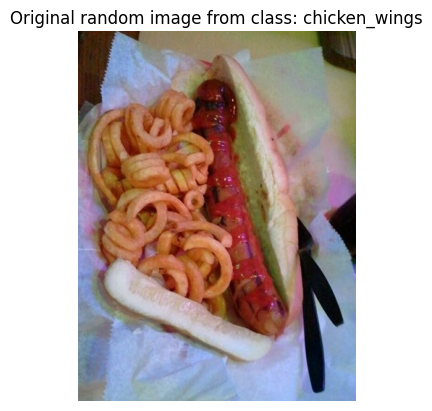

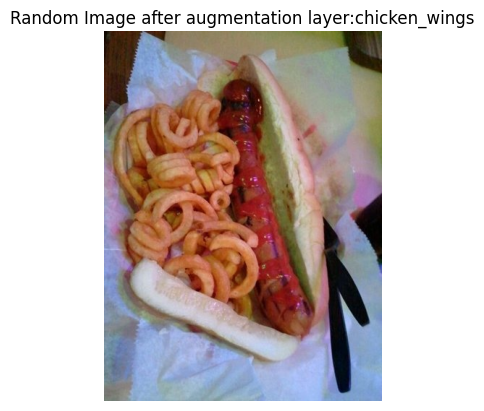

In [28]:
### Visualize our data augmentation layer(and see what happens to our data)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class=random.choice(train_data_1_percent.class_names)
target_dir="10_food_classes_1_percent/train/"+target_class
random_image=random.choice(os.listdir(target_dir))
random_image_path=target_dir+"/"+random_image

# Read in the random image
img=mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augemented_img=data_augmentation(img)
plt.figure()
plt.imshow(tf.squeeze(augemented_img)/255.)
plt.title(f"Random Image after augmentation layer:{target_class}")
plt.axis(False)

## Model 1:Feature Extraction Transfer Learning on 1% of the data with data augmentation

In [29]:
model_1_config={
    "architecture":"EfficientNet_B0",
    "num_classes": len(train_data_1_percent.class_names),
    "loss":"categorical_crossentropy",
    "learning_rate":0.001,
    "optimizer":"Adam",
    "batch_size":BATCH_SIZE,
    "epochs":10,
    "dataset":"ImageNet",
    "dataset_fraction":"1%"
}

In [41]:
wandb.init(project="Transfer Learning Feature Extraction",
           name="model_1 with 1% training data only(3rd Run)",
           config=model_1_config)

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


accuracy,▁▂▃▃▄▅▇▇▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▆▅▄▄▃▂▂▁
val_accuracy,▁▂▃▄▅▆▇▇██
val_loss,█▇▆▅▄▃▃▂▂▁
accuracy,0.9
best_epoch,9
best_val_loss,1.63897
epoch,9
loss,1.24662
val_accuracy,0.502


In [42]:
# Setup input shape and base model,freezing the base model layers
input_shape=(224,224,3)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

# Create the input layer
inputs=layers.Input(shape=input_shape,name="input_shape")

# Add in data augmentation Sequential model as a layer
x=data_augmentation(inputs)

# Give the base_model the inputs (after augmentation) and don't train it
x=base_model(x,training=False)

# Pool output features of the base model
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the ouput 
outputs=layers.Dense(10,activation="softmax",name="output_layer")(x)

# Make a model using the inputs and ouputs
model_1=keras.Model(inputs,outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1=model_1.fit(train_data_1_percent,
                      steps_per_epoch=len(train_data_1_percent),
                      epochs=10,
                      validation_data=test_data_1_percent,
                      validation_steps=len(test_data_1_percent),
                      callbacks=[WandbCallback()]
                      )

Epoch 1/10


3/3 [==============================] - ETA: 0s - loss: 2.4073 - accuracy: 0.0286   WARNING:tensorflow:Model was constructed with shape (512, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(512, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 65s 28s/step - loss: 2.4073 - accuracy: 0.0286 - val_loss: 2.2534 - val_accuracy: 0.1440
Epoch 2/10
3/3 [==============================] - ETA: 0s - loss: 2.1887 - accuracy: 0.2143WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 76s 38s/step - loss: 2.1887 - accuracy: 0.2143 - val_loss: 2.1447 - val_accuracy: 0.2300
Epoch 3/10
3/3 [==============================] - ETA: 0s - loss: 2.0132 - accuracy: 0.3714WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 68s 34s/step - loss: 2.0132 - accuracy: 0.3714 - val_loss: 2.0515 - val_accuracy: 0.3084
Epoch 4/10
3/3 [==============================] - ETA: 0s - loss: 1.8538 - accuracy: 0.5571WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 63s 31s/step - loss: 1.8538 - accuracy: 0.5571 - val_loss: 1.9656 - val_accuracy: 0.3648
Epoch 5/10
3/3 [==============================] - ETA: 0s - loss: 1.7411 - accuracy: 0.5143WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 54s 27s/step - loss: 1.7411 - accuracy: 0.5143 - val_loss: 1.8891 - val_accuracy: 0.4188
Epoch 6/10
3/3 [==============================] - ETA: 0s - loss: 1.5955 - accuracy: 0.7000WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 61s 30s/step - loss: 1.5955 - accuracy: 0.7000 - val_loss: 1.8176 - val_accuracy: 0.4636
Epoch 7/10
3/3 [==============================] - ETA: 0s - loss: 1.4953 - accuracy: 0.7143WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 55s 27s/step - loss: 1.4953 - accuracy: 0.7143 - val_loss: 1.7486 - val_accuracy: 0.4964
Epoch 8/10
3/3 [==============================] - ETA: 0s - loss: 1.3965 - accuracy: 0.7143WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 55s 27s/step - loss: 1.3965 - accuracy: 0.7143 - val_loss: 1.6828 - val_accuracy: 0.5264
Epoch 9/10
3/3 [==============================] - ETA: 0s - loss: 1.3356 - accuracy: 0.7571WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 53s 27s/step - loss: 1.3356 - accuracy: 0.7571 - val_loss: 1.6190 - val_accuracy: 0.5496
Epoch 10/10
3/3 [==============================] - ETA: 0s - loss: 1.2143 - accuracy: 0.8143WARNING:tensorflow:Model was constructed with shape (None, 382, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 382, 3), dtype=tf.uint8, name='random_flip_5_input'), name='random_flip_5_input', description="created by layer 'random_flip_5_input'"), but it was called on an input with incompatible shape (None, 224, 224, 3).


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\vudut\OneDrive\Desktop\Python\TensorFlow\Daniel Bourke Course\wandb\run-20250703_002538-n1mefvk3\files\model-best)... Done. 0.1s


3/3 [==============================] - 47s 23s/step - loss: 1.2143 - accuracy: 0.8143 - val_loss: 1.5603 - val_accuracy: 0.5692


** This is for clearing out the weights and baises old logs that are being stored locally**
>*!wandb sync --clean --clean-old-hours 0*

## Model 2: Feature Extraction Transfer Learning Modele with 10% of data and data augmentation

In [5]:
# Get 10% of data...
train_dir_10_percent="10_food_classes_10_percent/train"
test_dir="10_food_classes_10_percent/test"

In [6]:
# Set the data inputs
import tensorflow as tf
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_10_percent=tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                          label_mode="categorical",
                                                                          image_size=IMG_SIZE)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              label_mode="categorical",
                                                              image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [7]:
# How amny images are in our directories
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent\test'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent\test\steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [9]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_height (RandomHeight  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 random_width (RandomWidth)  (None, 224, 224, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

In [8]:
# Create model 2 with data augmentation built in
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential

# Bulid data augmentaion layer
data_augmentation=Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    # preprocessing.Rescaling(1./255) if you are using a model such as ResNet50v2,yu'll need to rescale our data,efficientnet has rescaling built-in
],   name="data_augmentation")    

# Setup the input shape to our model
input_shape=(224,224,3)

# Create a frozen base model (also called the backbone)
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

# Create the inputs and outputs (including the layers in between)
inputs=layers.Input(shape=input_shape,name="input_layer")
x=data_augmentation(inputs) # Augemnt our training images
x=base_model(x,training=False) # Passing augmented images to base model but keep it in inference mode, this also insures batch normalization layers don't get updated.
x=layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
outputs=layers.Dense(10,activation="softmax",name="output_layer")(x)
model_2=tf.keras.Model(inputs,outputs)

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics="accuracy")

In [10]:
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                             

### Creating a ModelCheckpoint Callback
The ModelCheckpoint callback intermediately saves our model(the full model or just the weights) during training.This is useful so we can come and start where we left off.

In [11]:
# Set the checkpoint path
checkpoint_path="ten_percent_model_checkpoint_weight/checkpoint.ckpt"

# Create a ModelCheckpoint callback that saves the model's weight only
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       save_best_only=False,
                                                       save_freq="epoch", # Save the model weights each for each and every epoch
                                                        verbose=1 )

In [12]:
model_2_config={
    "architecture":"EfficientNet_B0",
    "num_classes": len(train_data_10_percent.class_names),
    "loss":"categorical_crossentropy",
    "learning_rate":0.001,
    "optimizer":"Adam",
    "batch_size":BATCH_SIZE,
    "epochs":10,
    "dataset":"ImageNet",
    "dataset_fraction":"10%"
}

In [17]:
wandb.init(project="Transfer Learning Feature Extraction",
           name="model_2 with 10% training data with data augmentation",
           config=model_2_config)

In [14]:
# Fit the model_2 saving checkpoints every epoch
initial_epochs=5
history_2=model_2.fit(train_data_10_percent,
            epochs=initial_epochs,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=(0.25*len(test_data)),
            callbacks=checkpoint_callback # since the callback is a list we can pass in any number of things into taht list
            )

Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9386 - accuracy: 0.3653
Epoch 1: saving model to ten_percent_model_checkpoint_weight\checkpoint.ckpt
24/24 [==============================] - 11s 454ms/step - loss: 1.9386 - accuracy: 0.3653 - val_loss: 1.4743 - val_accuracy: 0.5891
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3584 - accuracy: 0.6733
Epoch 2: saving model to ten_percent_model_checkpoint_weight\checkpoint.ckpt
24/24 [==============================] - 9s 372ms/step - loss: 1.3584 - accuracy: 0.6733 - val_loss: 1.0667 - val_accuracy: 0.7453
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.7693
Epoch 3: saving model to ten_percent_model_checkpoint_weight\checkpoint.ckpt
24/24 [==============================] - 9s 372ms/step - loss: 1.0623 - accuracy: 0.7693 - val_loss: 0.8170 - val_accuracy: 0.8234
Epoch 4/5
24/24 [==============================] - ETA: 0s - loss: 0.9005 - accuracy: 0.7813
Epo

In [15]:
# Check model_2 results on all data
results_10_percent_data_aug=model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 4s 52ms/step - loss: 0.6369 - accuracy: 0.8360


[0.6369225382804871, 0.8359999656677246]

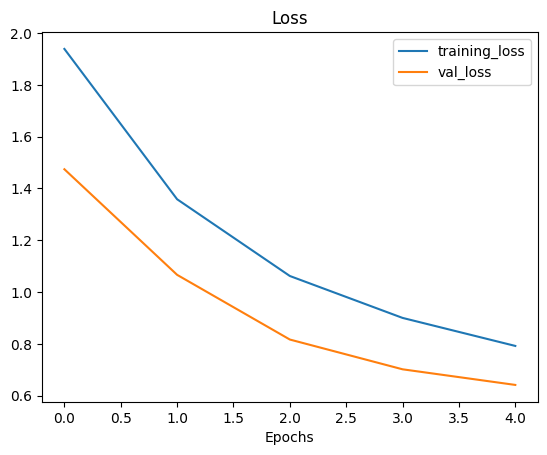

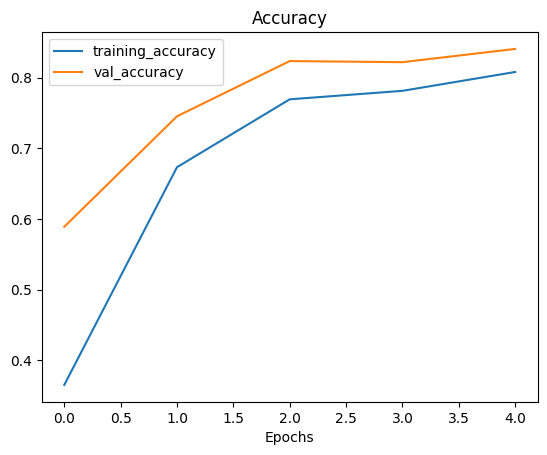

In [16]:
# Plot the model loss curves
plot_loss_curves(history_2)

###  Loading in checkpointed weights
Loading in checkpointed weights returns a model to a specific checkpoint

In [17]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path) 

In [18]:
# Evalute model_2 with loaded weights
loaded_weights_model_results=model_2.evaluate(test_data)

79/79 [==============================] - 4s 51ms/step - loss: 0.6369 - accuracy: 0.8360


In [19]:
# If the results from our previously evaluated model_2 match with loaded weights,everything has worked!
results_10_percent_data_aug==loaded_weights_model_results

False

In [20]:
results_10_percent_data_aug

[0.6369225382804871, 0.8359999656677246]

In [21]:
loaded_weights_model_results

[0.6369225978851318, 0.8359999656677246]

In [22]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(results_10_percent_data_aug),np.array(loaded_weights_model_results))

array([ True,  True])

In [23]:
# Check the difference between the two results  
abs(results_10_percent_data_aug[0]-loaded_weights_model_results[0])

5.960464477539063e-08

## Model 3: Fine tuning an exisiting model on 10% of the data